In [286]:
# library
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, FunctionTransformer, StandardScaler, MinMaxScaler
import seaborn as sns
import folium

In [353]:
train = pd.read_csv('./Data/titanic/train.csv')
test = pd.read_csv('./Data/titanic/test.csv')
submission = pd.read_csv('./Data/titanic/gender_submission.csv')

In [203]:
train_X = train.loc[:,'Pclass':]
train_y = train['Survived']

target_label = 'Survived'

In [204]:
test_X = test.loc[:,'Pclass':]

In [205]:
train_X

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [206]:
# 결측치 확인
train_X.isna().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [207]:
# 예측에 있어 필요하지 않은 변수 제거 : Name 제거
train_X = train_X[['Pclass','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']]
train_X

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,211536,13.0000,NaN,S
887,1,female,19.0,0,0,112053,30.0000,B42,S
888,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,male,26.0,0,0,111369,30.0000,C148,C


In [208]:
test_X = test_X.drop('Name', axis=1)
test_X

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,34.5,0,0,330911,7.8292,NaN,Q
1,3,female,47.0,1,0,363272,7.0000,NaN,S
2,2,male,62.0,0,0,240276,9.6875,NaN,Q
3,3,male,27.0,0,0,315154,8.6625,NaN,S
4,3,female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1,female,39.0,0,0,PC 17758,108.9000,C105,C
415,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,male,NaN,0,0,359309,8.0500,NaN,S


# EDA

## Pclass

In [209]:
# Pclass

# not in NA value
train_X['Pclass'].isna().sum()

0

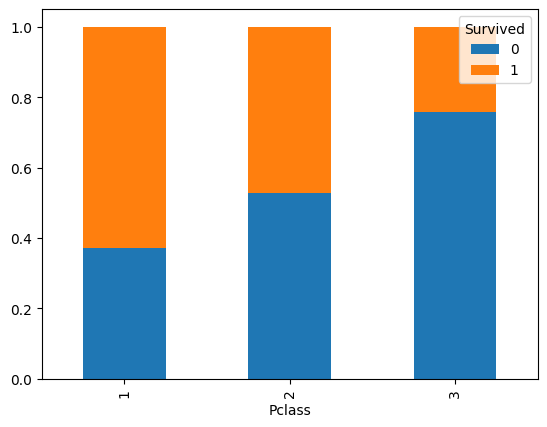

In [210]:
var_label = 'Pclass'

df_data = train_X[[var_label]].join(train['Survived'])

df_plot_ = (
    df_data.groupby(var_label)['Survived']
    .apply(lambda g: g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index=var_label, columns=target_label, values='frac')
)

df_plot.plot.bar(stacked=True)
plt.show()

# 분석결과
# Pclass가 높은 순서대로 생존율이 높아진다

In [211]:
train_X[var_label].value_counts(normalize=True)*100

Pclass
3    55.106622
1    24.242424
2    20.650954
Name: proportion, dtype: float64

In [212]:
ohe_encoder = OneHotEncoder(sparse_output=False, dtype=int)
ohe_encoder.fit(train_X[[var_label]])
ohe_feats = ohe_encoder.get_feature_names_out()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [213]:
# train set
pclass_ohe_array_train = ohe_encoder.transform(train_X[[var_label]])
pclass_ohe_train = pd.DataFrame(pclass_ohe_array_train, columns=ohe_feats)
pclass_ohe_train

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
886,0,1,0
887,1,0,0
888,0,0,1
889,1,0,0


In [214]:
train_X = train_X.drop(var_label, axis=1).join(pclass_ohe_train)
train_X

,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,female,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,male,27.0,0,0,211536,13.0000,NaN,S,0,1,0
887,female,19.0,0,0,112053,30.0000,B42,S,1,0,0
888,female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,0,1
889,male,26.0,0,0,111369,30.0000,C148,C,1,0,0


In [215]:
# test set
pclass_ohe_array_test = ohe_encoder.transform(test[[var_label]])
pclass_ohe_test = pd.DataFrame(pclass_ohe_array_test, columns=ohe_feats)
test_X = test_X.drop(var_label, axis=1).join(pclass_ohe_test)
test_X

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1
1,female,47.0,1,0,363272,7.0000,NaN,S,0,0,1
2,male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0
3,male,27.0,0,0,315154,8.6625,NaN,S,0,0,1
4,female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,0,1
414,female,39.0,0,0,PC 17758,108.9000,C105,C,1,0,0
415,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,0,1
416,male,NaN,0,0,359309,8.0500,NaN,S,0,0,1


## Sex

In [216]:
var_label = 'Sex'

In [217]:
df_data = train[[var_label]].join(train_y)

df_plot_ = (
    df_data
    .groupby(var_label)[target_label]
    .apply(lambda g:g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index=var_label, columns=target_label, values='frac')
)

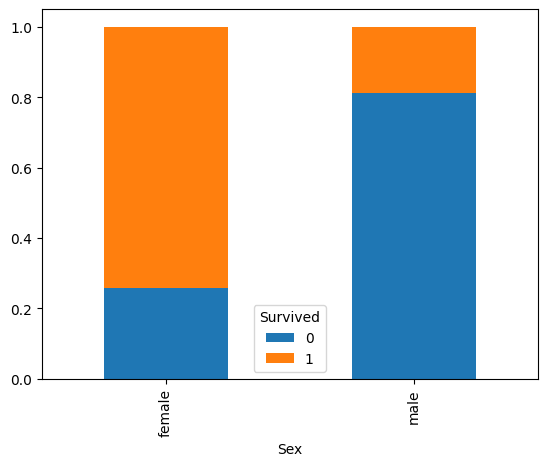

In [218]:
df_plot.plot.bar(stacked=True)
plt.show()

# 분석결과
# 남성보다 여성이 압도적으로 생존율이 높음
# 여성 먼저 탈출시켰던 것으로 보임

In [219]:
train_X[var_label].value_counts(normalize=True)

Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64

In [220]:
ohe_encoder_sex = OneHotEncoder(sparse_output=False, dtype=int)
ohe_encoder_sex.fit(train_X[[var_label]])
ohe_feats = ohe_encoder_sex.get_feature_names_out()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [221]:
sex_ohe_array_train = ohe_encoder_sex.transform(train_X[[var_label]])
sex_ohe_train = pd.DataFrame(sex_ohe_array_train, columns=ohe_feats)
train_X = train_X.drop(var_label, axis=1).join(sex_ohe_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [222]:
sex_ohe_array_test = ohe_encoder_sex.transform(test_X[[var_label]])
sex_ohe_test = pd.DataFrame(sex_ohe_array_test, columns=ohe_feats)
test_X = test_X.drop(var_label, axis=1).join(sex_ohe_test)
test_X

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,1
1,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0
2,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1
3,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1
4,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,0,1,0,1
414,39.0,0,0,PC 17758,108.9000,C105,C,1,0,0,1,0
415,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,0,1,0,1
416,NaN,0,0,359309,8.0500,NaN,S,0,0,1,0,1


## Age

In [223]:
var_label = 'Age'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


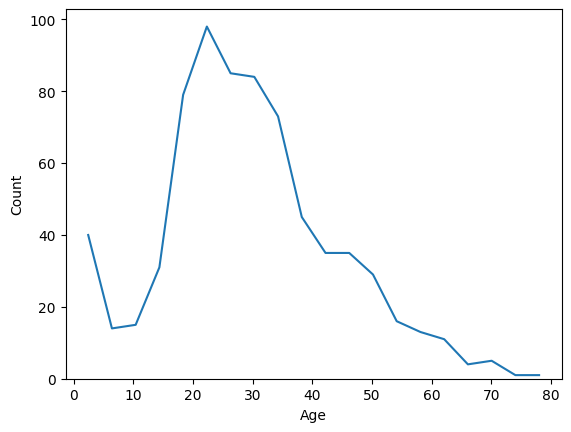

In [224]:
sns.histplot(data=train_X[var_label], element='poly', fill=False)
plt.show()

In [225]:
# check the na value
train_X[var_label].isna().sum()

177

In [226]:
# 결측치 대체
train_X[var_label].median()

28.0

In [227]:
# 중앙값이 최빈값과 유사하기 때문에 중앙값으로 NA값을 대체
train_X[var_label].fillna(train_X[var_label].median(), inplace=True)
train_X[var_label].isna().sum()

0

In [228]:
# 나이를 20대, 30대와 같은 식으로 cluster 생성
train_X['Age_Cluster'] = pd.cut(train_X[var_label], bins=range(0, 101, 10), right=False, labels=range(0, 91, 10))

In [229]:
df_data = pd.DataFrame(train_X['Age_Cluster']).join(train_y)

In [230]:
# 연령대에 따라서 Survived가 어떻게 달라졌는지 확인
df_plot_ = (
    df_data
    .groupby('Age_Cluster')[target_label]
    .apply(lambda g:g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index='Age_Cluster', columns=target_label, values='frac')
)

/var/folders/m_/v6sgxc755k927vw2qyfzf9bh0000gn/T/ipykernel_38667/2283454311.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Age_Cluster')[target_label]


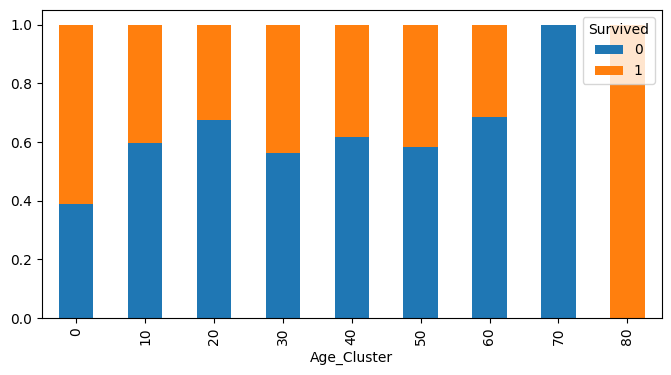

In [231]:
# visualization
df_plot.plot.bar(stacked=True, figsize=(8,4))
plt.show()

# 분석결과
# 80대는 모두 생존, 70대는 모두 생존한 것으로 확인할 수 있음
# 10대 이하 경우, survived의 경우가 non-survived보다 많음을 확인할 수 있음

In [232]:
# test_X의 경우도 위와 동일하게 처리

# 86개의 결측치
test_X[var_label].isna().sum()

# 86개의 결측치를 중앙값으로 대치
test_X[var_label].fillna(test_X[var_label].median(), inplace=True)

# Age를 Age_Cluster로 묶기
test_X['Age_Cluster'] = pd.cut(test_X[var_label], bins=range(0, 101, 10), right=False, labels=range(0, 91, 10))

## SibSp
: 타이타닉에 탑승한 형제자매 / 배우자 수

In [235]:
var_label = 'SibSp'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='SibSp', ylabel='count'>

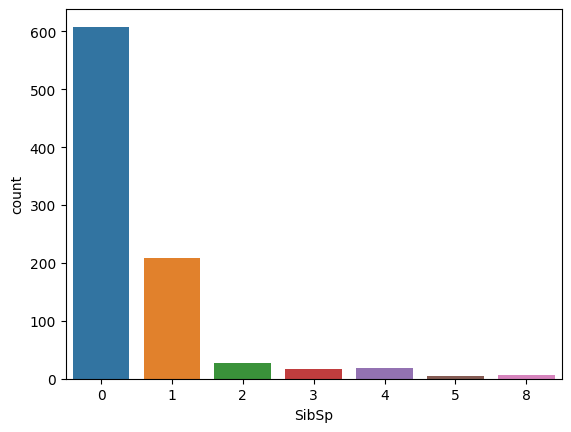

In [236]:
sns.countplot(x=train_X[var_label])

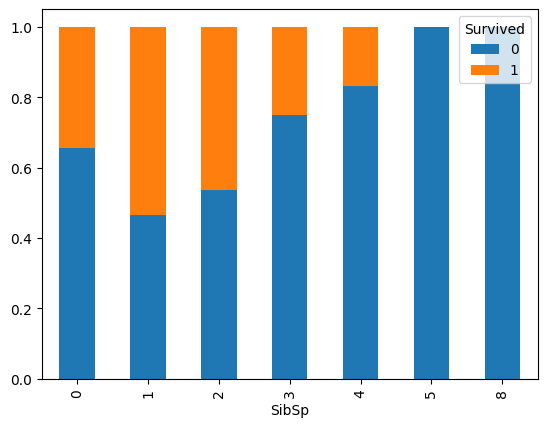

In [237]:
df_data = train[[var_label]].join(train_y)

df_plot_ = (
    df_data
    .groupby(var_label)[target_label]
    .apply(lambda g:g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index=var_label, columns=target_label, values='frac')
)

df_plot.plot.bar(stacked=True)
plt.show()

# 분석결과
# 동반한 가족의 수가 3이상의 경우부터 급격하게 생존율이 낮아지는 것으로 보임
# 5명 이상의 경우는 모두 사망

## Parch
타이타닉에 탑승한 부모/자녀의 수

In [238]:
var_label = 'Parch'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Parch', ylabel='count'>

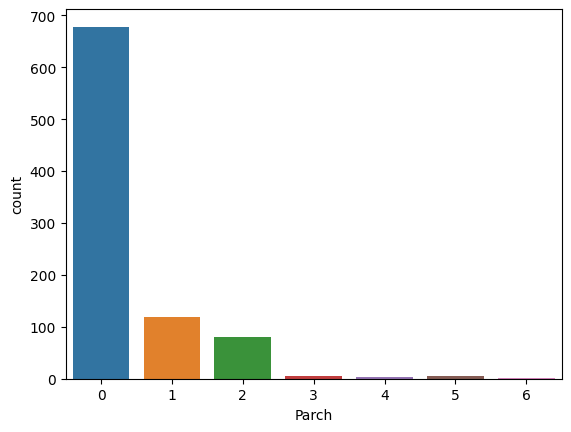

In [239]:
sns.countplot(x=train_X[var_label])

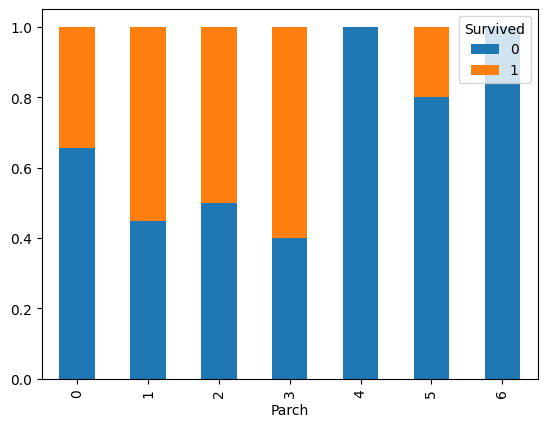

In [240]:
df_data = train[[var_label]].join(train_y)

df_plot_ = (
    df_data
    .groupby(var_label)[target_label]
    .apply(lambda g:g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index=var_label, columns=target_label, values='frac')
)

df_plot.plot.bar(stacked=True)
plt.show()

# 분석결과
# 4명이상부터 급격하게 생존율이 낮아지는 것으로 보임


In [241]:
# 가족, 친구, 배우자, 부모님 등 동반한 동반자의 수를 통합하여 하나의 컬럼으로 지정
train_X['Companion'] = train_X['SibSp'] + train_X['Parch']

In [242]:
# test_X도 동일하게 진행
test_X['Companion'] = test_X['SibSp'] + test_X['Parch']

## Companion
siblings, spouses, parents, children aboard the Titanic

In [243]:
var_label = 'Companion'

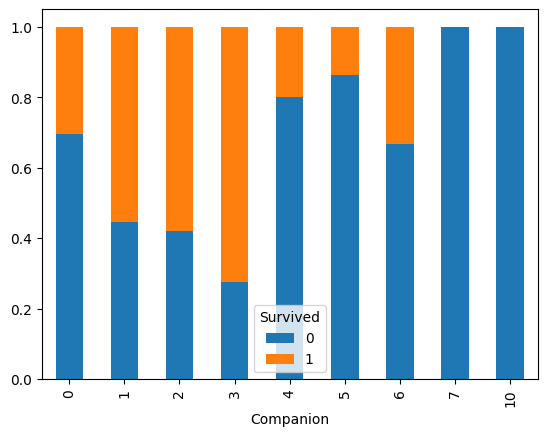

In [244]:
df_data = train_X[[var_label]].join(train_y)

df_plot_ = (
    df_data
    .groupby(var_label)[target_label]
    .apply(lambda g:g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index=var_label, columns=target_label, values='frac')
)

df_plot.plot.bar(stacked=True)
plt.show()

# 분석결과
# 함께 동반한 동반자의 수가 4명 이상인 경우 생존율이 매우 떨어지는 것으로 보임
# 또한 함께 동반한 동반자의 수가 0인 경우에도 1,2,3에 비해 떨어진다
# 0의 경우는 다른 사람들을 먼저 구조할 수 있도록 도운 것으로 예상되며, 많을수록 동반자를 챙긴것으로 보임


In [151]:
# make the Companion Cluster
train_X['Companion_Cluster'] = df_data['Companion'].apply(lambda x: 0 if x < 4 or x == 0 else 1)

## Ticket

In [245]:
# ticket은 별다른 중요도를 가지고 있다고 판단하여 drop
train_X.drop(columns='Ticket', axis=1, inplace=True)

In [247]:
test_X.drop(columns='Ticket', axis=1, inplace=True)

## Fare
승객요금

In [248]:
var_label = 'Fare'

In [249]:
# 결측치 확인
train_X[var_label].isna().sum()

0

In [250]:
# 승객요금은 Pclass와 연관되어 있을 것이라 생각
# 특별하게 연관되어 있지 않은 것으로 보임
# Pclass가 2인 경우와 3인 경우는 Fare로써 특별한 차이가 없다고 판단
# 예매한 Ticket 혹은 좌석까지 연관되어 있을 가능성으로 확인됨

# Pclass == 3
train[train[['Pclass','Fare']]['Pclass'] == 3][['Pclass','Fare']].describe()

,Pclass,Fare
count,491.0,491.000000
mean,3.0,13.675550
std,0.0,11.778142
min,3.0,0.000000
25%,3.0,7.750000
50%,3.0,8.050000
75%,3.0,15.500000
max,3.0,69.550000


In [251]:
# Pclass == 2
train[train[['Pclass','Fare']]['Pclass'] == 2][['Pclass','Fare']].describe()

,Pclass,Fare
count,184.0,184.000000
mean,2.0,20.662183
std,0.0,13.417399
min,2.0,0.000000
25%,2.0,13.000000
50%,2.0,14.250000
75%,2.0,26.000000
max,2.0,73.500000


In [252]:
# Pclass == 1
train[train[['Pclass','Fare']]['Pclass'] == 1][['Pclass','Fare']].describe()

,Pclass,Fare
count,216.0,216.000000
mean,1.0,84.154687
std,0.0,78.380373
min,1.0,0.000000
25%,1.0,30.923950
50%,1.0,60.287500
75%,1.0,93.500000
max,1.0,512.329200


In [253]:
# 상관계수 또한 -0.5수준으로 -1과 1사이에서 크게 좌우하지 않는 것으로 판단됨
# 독립된 변수로 생각하여 분석에 사용
train[['Pclass','Fare']].corr().iloc[0,1]

-0.5494996199439076

In [258]:
df_data = train[['Fare','Survived']]

df_data['Fare_Cluster'] = pd.qcut(train_X['Fare'], q=4, labels=False, precision=2)

/var/folders/m_/v6sgxc755k927vw2qyfzf9bh0000gn/T/ipykernel_38667/2187713278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['Fare_Cluster'] = pd.qcut(train_X['Fare'], q=4, labels=False, precision=2)


In [259]:
var_label = 'Fare_Cluster'

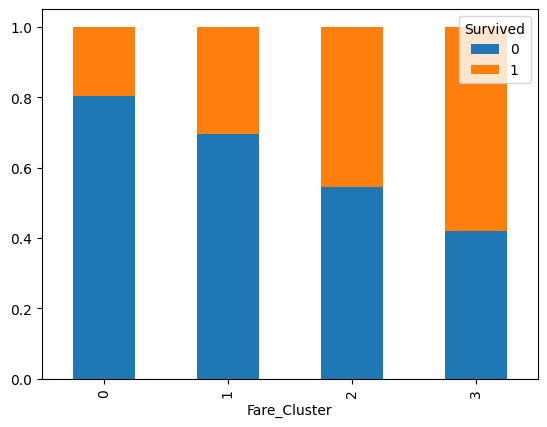

In [261]:
#df_data = train_X[[var_label]].join(train_y)

df_plot_ = (
    df_data
    .groupby(var_label)[target_label]
    .apply(lambda g:g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index=var_label, columns=target_label, values='frac')
)

df_plot.plot.bar(stacked=True)
plt.show()

# 분석결과
# Fare이 높을수록 Survived가 올라간다


In [263]:
train_X['Fare_Cluster'] = pd.qcut(train_X['Fare'], q=4, labels=False, precision=2)

In [271]:
# test_X에 대해서도 동일하게 진행

# 결측치 확인
test_X['Fare'].isna().sum() # 1

# Pclass 확인
test[test['Fare'].isna()]  # Pclass == 3

test[test['Pclass']==3]['Fare'].mean() # 12.459677880184334

# Pclass가 3인 경우의 Fare 평균으로 NA값 대체
test_X['Fare'].fillna(value=test[test['Pclass']==3]['Fare'].mean(), inplace=True)

In [272]:
test_X['Fare_Cluster'] = pd.qcut(test_X['Fare'], q=4, labels=False, precision=2)

## Cabin
Cabin number

In [275]:
train_X['Cabin'].isna().sum()

687

In [276]:
test_X['Cabin'].isna().sum()

327

In [280]:
# 결측치가 매우 많아 데이터분석에 사용하는 것이 부적절하다고 생각됨
# train과 test에서 모두 제거
train_X.drop(columns='Cabin', inplace=True)
test_X.drop(columns='Cabin', inplace=True)

## Embarked
Port of Embarkation

In [284]:
var_label = 'Embarked'

In [282]:
train_X['Embarked'].isna().sum()

2

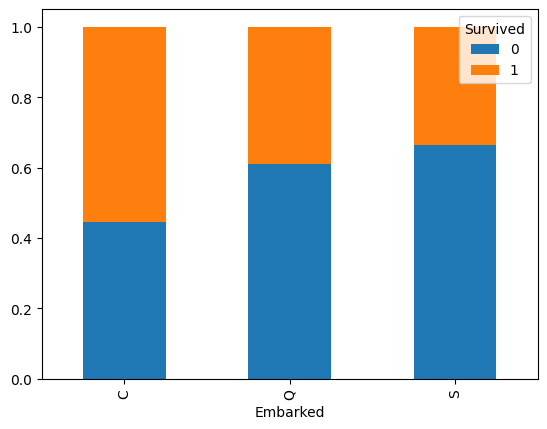

In [285]:
df_data = train_X[[var_label]].join(train_y)

df_plot_ = (
    df_data
    .groupby(var_label)[target_label]
    .apply(lambda g:g.value_counts(normalize=True))
    .reset_index()
)

df_plot = (
    df_plot_
    .rename({df_plot_.columns[1]:target_label, target_label:'frac'}, axis=1)
    .pivot(index=var_label, columns=target_label, values='frac')
)

df_plot.plot.bar(stacked=True)
plt.show()

# 분석결과
# C = Cherbourg, Q = Queenstown, S = Southampton
# 타이타닉 호의 이동 순서 : Southampton(출발지) -> Cherbourg(첫 번째 항구) -> Queenstown(두 번째 항구)


In [287]:
# 각 항구를 분석하기 위해 위치를 map에 표시

# Cherbourg의 위치 (프랑스)
cherbourg_coords = (49.6419, -1.6236)

# Queenstown(Cobh)의 위치 (아일랜드)
queenstown_coords = (51.8503, -8.2943)

# Southampton의 위치 (영국)
southampton_coords = (50.9097, -1.4044)

# 지도 생성
map_titanic_ports = folium.Map(location=cherbourg_coords, zoom_start=5)

# 각 항구에 마커 추가
folium.Marker(location=cherbourg_coords, popup='Cherbourg').add_to(map_titanic_ports)
folium.Marker(location=queenstown_coords, popup='Queenstown').add_to(map_titanic_ports)
folium.Marker(location=southampton_coords, popup='Southampton').add_to(map_titanic_ports)

# 지도 표시
map_titanic_ports

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Embarked', ylabel='Fare'>

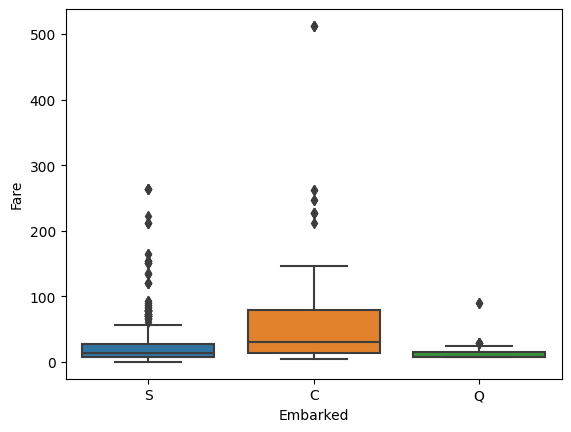

In [304]:
sns.boxplot(data = train,
            y = 'Fare',
            x = var_label)

# 대체적으로 C에서 탑승한 사람의 Fare가 높은 것으로 확인됨
# C에서 탑승한 사람들의 Survived 비율이 높은 이유는 이와 관련되어 있지 않을까 생각함
# 딱히 중요한 변수가 아닐수도 있겠다

In [317]:
# 가장 많이 등장한 값으로 결측치 대체
# test_X에는 Embarked에 대한 결측치는 없는 것으로 확인됨
train_X['Embarked'].fillna(train_X['Embarked'].value_counts().idxmax(), inplace=True)

In [320]:
# tranform to dummy
ohe_encoder_embarked = OneHotEncoder(sparse_output=False, dtype=int)
ohe_encoder_embarked.fit(train_X[[var_label]])
ohe_feats = ohe_encoder_embarked.get_feature_names_out()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [323]:
# train set
embarked_ohe_array_train = ohe_encoder_embarked.transform(train_X[[var_label]])
embarked_ohe_train = pd.DataFrame(embarked_ohe_array_train, columns=ohe_feats)
train_X = train_X.drop(var_label, axis=1).join(embarked_ohe_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [324]:
# test set
embarked_ohe_array_test = ohe_encoder_embarked.transform(train_X[[var_label]])
embarked_ohe_train = pd.DataFrame(embarked_ohe_array_train, columns=ohe_feats)
train_X = train_X.drop(var_label, axis=1).join(embarked_ohe_train)
train_X

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_Cluster,Companion,Fare_Cluster,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,1,20,1,0,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,30,1,3,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,20,0,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,1,0,30,1,3,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,1,30,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,0,1,0,0,1,20,0,1,0,0,1
887,19.0,0,0,30.0000,1,0,0,1,0,10,0,2,0,0,1
888,28.0,1,2,23.4500,0,0,1,1,0,20,3,2,0,0,1
889,26.0,0,0,30.0000,1,0,0,0,1,20,0,2,1,0,0


In [326]:
embarked_ohe_array_test = ohe_encoder_embarked.transform(test_X[[var_label]])
embarked_ohe_test = pd.DataFrame(embarked_ohe_array_test, columns=ohe_feats)
test_X = test_X.drop(var_label, axis=1).join(embarked_ohe_test)
test_X

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_Cluster,Companion,Fare_Cluster,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0,0,1,0,1,30,0,0,0,1,0
1,47.0,1,0,7.0000,0,0,1,1,0,40,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,60,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,20,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,20,2,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,27.0,0,0,8.0500,0,0,1,0,1,20,0,1,0,0,1
414,39.0,0,0,108.9000,1,0,0,1,0,30,0,3,1,0,0
415,38.5,0,0,7.2500,0,0,1,0,1,30,0,0,0,0,1
416,27.0,0,0,8.0500,0,0,1,0,1,20,0,1,0,0,1


# Modeling

## Logistic regression(LR)

In [342]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [333]:
## training
# X : train_X.iloc[:,4:]
# y : train_y
LRmodel = LogisticRegression(random_state=42).fit(train_X.iloc[:,4:], train_y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

In [344]:
LR_train_predict = LRmodel.predict(train_X.iloc[:,4:])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [345]:
# train accuracy
accuracy_score(train_y, LR_train_predict)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is depreca

0.7946127946127947

In [347]:
LR_test_predict = LRmodel.predict(test_X.iloc[:,4:])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [355]:
submission['Survived'] = LR_test_predict

In [358]:
# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# LR score : 0.7488

## DecisionTreeClassifier(DTC)

In [359]:
from sklearn.tree import DecisionTreeClassifier

In [365]:
# create the model
DTCmodel = DecisionTreeClassifier()

# training
DTCmodel.fit(train_X.iloc[:,4:], train_y)

DTC_train_predict = DTCmodel.predict(train_X.iloc[:,4:])

# DTC_train accuracy score
accuracy_score(train_y, DTC_train_predict)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

0.8933782267115601

In [369]:
# testing
DTC_test_predict = DTCmodel.predict(test_X.iloc[:,4:])

# submission에 저장
submission['Survived'] = DTC_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# DTC score : 0.75598

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## KNeighborsClassifier

In [370]:
from sklearn.neighbors import KNeighborsClassifier

In [376]:
knnmodel = KNeighborsClassifier(n_neighbors=3)

knnmodel.fit(train_X.iloc[:,4:], train_y)

KNN_train_predict = knnmodel.predict(train_X.iloc[:,4:])

accuracy_score(train_y, KNN_train_predict)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

0.8585858585858586

In [377]:
# testing
KNN_test_predict = knnmodel.predict(test_X.iloc[:,4:])

# submission에 저장
submission['Survived'] = KNN_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# KNN score : 0.73923

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# Feature Selection

In [378]:
from sklearn.ensemble import RandomForestClassifier

In [395]:
# training

RFmodel = RandomForestClassifier(n_estimators=100, random_state=42)
RFmodel.fit(train_X.iloc[:,4:], train_y)

# Feature importance 확인
feature_importance = RFmodel.feature_importances_

feature_importance = list(zip(train_X.iloc[:,4:].columns, feature_importance))

# 숫자를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# 결과 출력
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Age_Cluster: 0.20123258170350453
Sex_male: 0.18995984304422694
Sex_female: 0.1890843763566034
Companion: 0.12772447503483375
Fare_Cluster: 0.10063040335886746
Pclass_3: 0.08420314844282852
Pclass_1: 0.036529123943305104
Pclass_2: 0.02207267104087126
Embarked_S: 0.019832431201773554
Embarked_C: 0.01896129707516214
Embarked_Q: 0.009769648798023289


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

In [398]:
# Embarked 변수를 제거하여 test 진행
train_X.iloc[:,4:12]

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_Cluster,Companion,Fare_Cluster
0,0,0,1,0,1,20,1,0
1,1,0,0,1,0,30,1,3
2,0,0,1,1,0,20,0,1
3,1,0,0,1,0,30,1,3
4,0,0,1,0,1,30,0,1
...,...,...,...,...,...,...,...,...
886,0,1,0,0,1,20,0,1
887,1,0,0,1,0,10,0,2
888,0,0,1,1,0,20,3,2
889,1,0,0,0,1,20,0,2


# Modeling after Feature Selection

## Logistic regression(LR)

In [402]:
## training
# X : train_X.iloc[:,4:12]
# y : train_y
after_LRmodel = LogisticRegression(random_state=42).fit(train_X.iloc[:,4:12], train_y)

after_LR_train_predict = after_LRmodel.predict(train_X.iloc[:,4:12])

# train accuracy
accuracy_score(train_y, after_LR_train_predict)

after_LR_test_predict = after_LRmodel.predict(test_X.iloc[:,4:12])

submission['Survived'] = after_LR_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# LR score (after feature selection) : 0.7488

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

## DecisionTreeClassifier(DTC)

In [405]:
# create the model
after_DTCmodel = DecisionTreeClassifier()

# training
after_DTCmodel.fit(train_X.iloc[:,4:12], train_y)

after_DTC_train_predict = after_DTCmodel.predict(train_X.iloc[:,4:12])

# DTC_train accuracy score
accuracy_score(train_y, after_DTC_train_predict)

# testing
after_DTC_test_predict = after_DTCmodel.predict(test_X.iloc[:,4:12])

# submission에 저장
submission['Survived'] = after_DTC_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# DTC score (after feature selection) : 0.75837

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

## KNeighborsClassifier

In [435]:
after_knnmodel = KNeighborsClassifier(n_neighbors=4)

after_knnmodel.fit(train_X.iloc[:,4:12], train_y)

after_KNN_train_predict = after_knnmodel.predict(train_X.iloc[:,4:12])

accuracy_score(train_y, after_KNN_train_predict)

# testing
after_KNN_test_predict = after_knnmodel.predict(test_X.iloc[:,4:12])

# submission에 저장
submission['Survived'] = after_KNN_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# KNN score (after feature selection) : 0.76555

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

In [440]:
train_X.iloc[:,7:12]

,Sex_female,Sex_male,Age_Cluster,Companion,Fare_Cluster
0,0,1,20,1,0
1,1,0,30,1,3
2,1,0,20,0,1
3,1,0,30,1,3
4,0,1,30,0,1
...,...,...,...,...,...
886,0,1,20,0,1
887,1,0,10,0,2
888,1,0,20,3,2
889,0,1,20,0,2


In [441]:
# Feature : Sex_female, Sex_male, Age_Cluster, Companion, Fare_Cluster

,Sex_female,Sex_male,Age_Cluster,Companion,Fare_Cluster
0,0,1,20,1,0
1,1,0,30,1,3
2,1,0,20,0,1
3,1,0,30,1,3
4,0,1,30,0,1
...,...,...,...,...,...
886,0,1,20,0,1
887,1,0,10,0,2
888,1,0,20,3,2
889,0,1,20,0,2


# Modeling after Feature Selection 2

In [442]:
after_LRmodel = LogisticRegression(random_state=42).fit(train_X.iloc[:,7:12], train_y)

after_LR_train_predict = after_LRmodel.predict(train_X.iloc[:,7:12])

# train accuracy
print(accuracy_score(train_y, after_LR_train_predict))

after_LR_test_predict = after_LRmodel.predict(test_X.iloc[:,7:12])

submission['Survived'] = after_LR_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# LR score (after feature selection) : 0.75837

0.7856341189674523


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

## DecisionTreeClassifier(DTC)

In [443]:
# create the model
after_DTCmodel = DecisionTreeClassifier()

# training
after_DTCmodel.fit(train_X.iloc[:,7:12], train_y)

after_DTC_train_predict = after_DTCmodel.predict(train_X.iloc[:,7:12])

# DTC_train accuracy score
accuracy_score(train_y, after_DTC_train_predict)

# testing
after_DTC_test_predict = after_DTCmodel.predict(test_X.iloc[:,7:12])

# submission에 저장
submission['Survived'] = after_DTC_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# DTC score (after feature selection) : 0.74162

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

## KNeighborsClassifier

In [444]:
after_knnmodel = KNeighborsClassifier(n_neighbors=4)

after_knnmodel.fit(train_X.iloc[:,7:12], train_y)

after_KNN_train_predict = after_knnmodel.predict(train_X.iloc[:,7:12])

accuracy_score(train_y, after_KNN_train_predict)

# testing
after_KNN_test_predict = after_knnmodel.predict(test_X.iloc[:,7:12])

# submission에 저장
submission['Survived'] = after_KNN_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# KNN score (after feature selection) : 0.76315

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

In [454]:
using_train_X = train_X.drop(columns=['SibSp','Parch','Age_Cluster','Fare_Cluster'], axis=1)
using_test_X = test_X.drop(columns=['SibSp','Parch','Age_Cluster','Fare_Cluster'], axis=1)

In [457]:
# create the model
DTCmodel_4 = DecisionTreeClassifier()

# training
DTCmodel_4.fit(using_train_X, train_y)

after_DTC_train_predict = DTCmodel_4.predict(using_train_X)

# DTC_train accuracy score
print(accuracy_score(train_y, after_DTC_train_predict))

# testing
after_DTC_test_predict = DTCmodel_4.predict(using_test_X)

# submission에 저장
submission['Survived'] = after_DTC_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# DTC score (after feature selection) : 0.74162

0.9797979797979798


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid

In [458]:
## training
after_LRmodel = LogisticRegression(random_state=42).fit(using_train_X, train_y)

after_LR_train_predict = after_LRmodel.predict(using_train_X)

# train accuracy
print(accuracy_score(train_y, after_LR_train_predict))

after_LR_test_predict = after_LRmodel.predict(using_test_X)

submission['Survived'] = after_LR_test_predict

# 위에서 예측한 결과를 csv 파일로 저장
submission.to_csv('./Data/titanic/gender_submission.csv', index=False)

# kaggle site를 통해 score 측정
# LR score (after feature selection) : 0.7488

0.8024691358024691


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/valid